## 피마 인디언 당뇨병 예측
- 모델 평가
    - 평가 지표

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler # 데이터 정규화
from sklearn.linear_model import LogisticRegression # 이진분류 문제이기 때문0

In [3]:
diabetes_data = pd.read_csv('../data/diabetes.csv')
print(diabetes_data['Outcome'].value_counts())  # 불균형 데이터 셋인지 확인

0    500
1    268
Name: Outcome, dtype: int64


불균형 데이터 => 정확도만 가지고 판단 할 수 없음

In [4]:
diabetes_data.head(3)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


#### 같은 범위에 들어가야 하기 때문에 Standard scare 사용할 수 밖에 없음

In [5]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [7]:
# 정확도, 정밀도, 재현율, f1-score, AUC 점수를 출력 함수
# 파라미터 : y_test => 테스트데이터 답, pred => 예측값
def get_clf_eval(y_test=None, pred=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [8]:
# 정밀도, 재현율 곡선 그리는 함수
# pred_proba_c1 : 답이 1인 예측 확률 
def precision_recall_curve_plot(y_test=None, pred_proba_c1=None):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

In [9]:
# 전체 데이터(diabetes_data) : 데이터 + 답 => 원래는 아웃컴을 가지고 나오라고 하는게 더 좋음
# 답을 가지고 추출하라 => outcome
 # 1. 데이터 추출
X = diabetes_data.iloc[:,:-1] # 컬럼에서 outcome을 제외하고 가져오기
# 2. 답 추출
y = diabetes_data.iloc[:,-1] # 마지막 컬럼만 가져옴

In [10]:
X.head(3)
# 여러개의 데이터가 나오는 것이 dataframe

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32


In [11]:
y.head(3)
# 하나만 나오는 것은 series

0    1
1    0
2    1
Name: Outcome, dtype: int64

In [12]:
# 학습데이터, 테스트데이터 분리
X_train, X_test, y_train, y_test = train_test_split(
       X
     , y
     , test_size=0.2 # 8대 2 비율로 나눔
     , random_state=156
 )

In [13]:
# 1. 모델 객체, 생성
lr_clf = LogisticRegression()
# 2. 학습 => 모델(식) 생성
lr_clf.fit(X_train, y_train)
# 3. 예측값
pred = lr_clf.predict(X_test)
# 4. 점수 출력(함수) => get_clf_avel()
get_clf_eval(y_test, pred)

오차 행렬
[[84 13]
 [25 32]]
정확도: 0.7532, 정밀도: 0.7111, 재현율: 0.5614,    F1: 0.6275, AUC:0.7137


C:\Users\dpqls\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [14]:
lr_clf.predict_proba(X_test).shape

(154, 2)

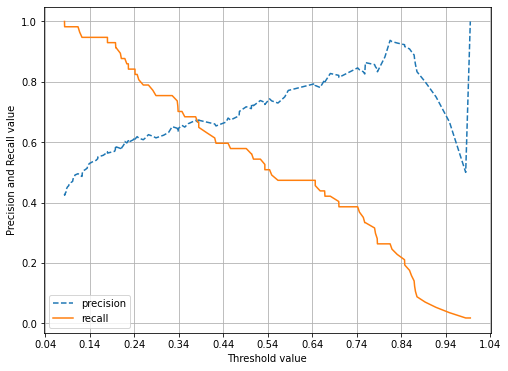

In [15]:
# [:, 1] : 답이 1인 예측 확률
pred_proba_c1 = lr_clf.predict_proba(X_test)[:,1]
precision_recall_curve_plot(y_test, pred_proba_c1)

In [16]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


이 데이터 셋에서 min이 0이 있다는 것은 뭔가 오류가 있다는 뜻!

(array([  5.,   0.,   4.,  32., 156., 211., 163.,  95.,  56.,  46.]),
 array([  0. ,  19.9,  39.8,  59.7,  79.6,  99.5, 119.4, 139.3, 159.2,
        179.1, 199. ]),
 <BarContainer object of 10 artists>)

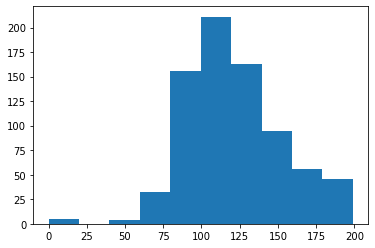

In [17]:
plt.hist(diabetes_data['Glucose'], bins=10)

- 막대 그래프는 비연속적임, 연속적인 값은 히스토그램을 사용!
- 데이터 파악, 컬럼의 용도를 파악하는 것이 제일 중요! 그래야 코드 진행이 됨!

In [18]:
# 0값이 들어있는 컬럼들을 검토 (개수, 퍼센트)
zero_features = ['Glucose', 'BloodPressure','SkinThickness','Insulin','BMI']

# 전체 데이터 건수
total_count = diabetes_data['Glucose'].count()

for feature in zero_features:
    zero_cnt = diabetes_data[diabetes_data[feature]==0][feature].count()
    pct_cnt = zero_cnt / total_count * 100 # 퍼센트를 구하는 식
    print_str = '{0} 0건수는 {1}, 퍼센트는 {2:.2f}'
    print(print_str.format(feature, zero_cnt, pct_cnt)) # 계산해서 집어넣는 것이 필요

Glucose 0건수는 5, 퍼센트는 0.65
BloodPressure 0건수는 35, 퍼센트는 4.56
SkinThickness 0건수는 227, 퍼센트는 29.56
Insulin 0건수는 374, 퍼센트는 48.70
BMI 0건수는 11, 퍼센트는 1.43


In [19]:
diabetes_data[diabetes_data['Glucose']==0]['Glucose'].count()

5

In [20]:
# zero_feature 리스트 내부에 저장된 개벌 feature들에 대해서
#  => 0값을 평균 값으로 대체
diabetes_data[zero_features] = \
diabetes_data[zero_features].replace(
      0
    , diabetes_data[zero_features].mean() 
)

In [21]:
# 데이터 / 답을 분리
X = diabetes_data.iloc[:,:-1]
y = diabetes_data.iloc[:,-1]

In [22]:
# 학습데이터, 테스트데이터 분리
X_train, X_test, y_train, y_test = train_test_split(
       X
     , y
     , test_size=0.2 # 8대 2 비율로 나눔
     , random_state=156
 )

In [23]:
# 1. 모델 객체, 생성
lr_clf = LogisticRegression()
# 2. 학습 => 모델(식) 생성
lr_clf.fit(X_train, y_train)
# 3. 예측값
pred = lr_clf.predict(X_test)
# 4. 점수 출력(함수) => get_clf_avel()
get_clf_eval(y_test, pred)

# =============아까 결과 ==========================
# 정확도: 0.7532, 정밀도: 0.7111, 재현율: 0.5614,
# F1: 0.6275, AUC:0.7137

오차 행렬
[[83 14]
 [25 32]]
정확도: 0.7468, 정밀도: 0.6957, 재현율: 0.5614,    F1: 0.6214, AUC:0.7085


C:\Users\dpqls\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [24]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.681605,72.254807,26.606479,118.660163,32.450805,0.471876,33.240885,0.348958
std,3.369578,30.436016,12.115932,9.631241,93.080358,6.875374,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,20.536458,79.799479,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,79.799479,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


#### 0값만 채운다고 해결될 문제가 아님

In [25]:
# 데이터 / 답을 분리
X = diabetes_data.iloc[:,:-1]
y = diabetes_data.iloc[:,-1]

In [28]:
# 스케일링 (정규화)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 학습데이터, 테스트데이터 분리
X_train, X_test, y_train, y_test = train_test_split(
       X_scaled
     , y
     , test_size=0.2 # 8대 2 비율로 나눔
     , random_state=156
    , stratify=y
 )

In [29]:
# 1. 모델 객체, 생성
lr_clf = LogisticRegression()
# 2. 학습 => 모델(식) 생성
lr_clf.fit(X_train, y_train)
# 3. 예측값
pred = lr_clf.predict(X_test)
# 4. 점수 출력(함수) => get_clf_avel()
get_clf_eval(y_test, pred)


# =============1차 모델 평가======================
# 정확도: 0.7532, 정밀도: 0.7111, 재현율: 0.5614,
# F1: 0.6275, AUC:0.7137
# =============2차 모델 평가======================
# 정확도: 0.7468, 정밀도: 0.6957, 재현율: 0.5614,
# F1: 0.6214, AUC:0.7085
# =============3차 모델 평가======================
# 정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111,    
# F1: 0.6804, AUC:0.7556

오차 행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111,    F1: 0.6804, AUC:0.7556


In [32]:
from sklearn.preprocessing import Binarizer
# 예시
X = [
    [-1, -1, 2],
    [2, 0, 0], 
    [0, 1.1, 1.2]
]
print(X)

[[-1, -1, 2], [2, 0, 0], [0, 1.1, 1.2]]


In [34]:
# 특정 기준 값 : 1.1 으로 나눌 수 있는 객체 생성
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]
